# Evolution of actors careers post-blockbuster in the film industry 

This notebook is dedicated to the preprocessing part of the project.

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset.

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in movie genre or type of characters** portrayed by actors after a significant hit?
- What are **significant features** from actors who have starred in blockbuster hits compared to less well-known actors?

In this notebook, we will first start by loading CMU Movies data, then include the external IMDb dataset and finish by inspecting the useful data to answer our problematic.

In [1]:
# Useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading existent data

We start by loading the data from the CMU Movies dataset into two pandas dataframe
- characters: dataframe containing information about actors and their associated movie characters
- movies: dataframe containing information about movies

In [2]:
# Define data paths
DATA_FOLDER = './MovieSummaries'
CHARACTER_DATASET = DATA_FOLDER + '/character.metadata.tsv'
MOVIE_DATASET = DATA_FOLDER + '/movie.metadata.tsv'
NAME_DATASET = DATA_FOLDER + '/name.clusters.txt'
PLOT_DATASET = DATA_FOLDER + '/plot_summaries.txt'
TVTROPES_DATASET = DATA_FOLDER + '/tvtropes.clusters.txt'

# Define column names
characters_columns = ['wikiID', 'movieID', 'releaseDate', 'charactName', 'birth', 'gender', 'height', 'ethnicity',
                      'name_actor', 'age', 'charActID', 'charID', 'actID']
movies_columns = ['wikiID', 'movieID', 'name_movie', 'releaseDate', 'revenue', 'runtime', 'languages',
                  'countries', 'genres']

# Load  data as pandas dataframes
characters = pd.read_table(CHARACTER_DATASET, header=None, names=characters_columns)
movies = pd.read_table(MOVIE_DATASET, header=None, names=movies_columns)

In [3]:
# Visualize characters data table
characters.head()

,wikiID,movieID,releaseDate,charactName,birth,gender,height,ethnicity,name_actor,age,charActID,charID,actID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [4]:
# Visualize movies data table
movies.head()

,wikiID,movieID,name_movie,releaseDate,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 2. Data examination and filtering

With such a large database, it is complex to find a model that both describes the career of an English celebrity in the 40's and that of an actor in Japan in the 2000's. Cultural and economical differences also make it difficult to find a common metric for success. Therefore, we would like to limit ourselves to a consistent and comprehensible subset of the data.

### 2.1 Feature selection
In order to restrain our dataset to relevant aspects for our analysis, we select the features from the database. The notion of success of an actor (detailed later in Matching.ipynb) depends on the number of movies they played in and their corresponding box office revenue. We're also interested in time features, to compare and describe timelines in the careers of actors. Finally, we'd like to have general information about the actors such as age, gender and ethnicity to mitigate a possible bias comming from a diffence in population distribution in our analysis

Thus, the **selected features** are:
* Actor name
* Actor date of birth or age at the time of the movie
* Actor gender
* Actor ethnicity
* Movie box office revenue
* Movie release date

In [5]:
# Make deep copies to preserve original data
characters_copy = characters.copy()
movies_copy = movies.copy()

# Delete unused columns and remove duplication
characters_copy = characters_copy.drop(columns=['charActID','charID','actID'])
characters_copy = characters_copy.drop_duplicates()

We'll merge our dataframes to work on a single subset of data. As we're interested in actors careers, we decide to populate the characters dataframe with information on the movies in which they appear. For this, we perfom a left merge on characters_copy with movies_copy

In [6]:
# Left merge on characters dataframe with movies dataframe
character_movies = pd.merge(characters_copy, movies_copy, on=['wikiID', 'movieID', 'releaseDate'] , how='left')

### 2.2 Amount of data
We'll now look at the **amount of information** available for each feature.

##### A. Movie revenue and date
Let's first look at the amount of data on **movie revenue** and **movie date** that is missing. We'll keep in mind that a movie can appear multiple times in this dataframe - we can have data about two different actors that appeared in the same movie.

In [7]:
# Compute the total number of movies
nb_movies = len(character_movies['movieID'].unique())

# Compute the number of movies for which we have "box office revenue"
character_movies_revenue = character_movies[['movieID', 'revenue']]
character_movies_revenue = character_movies_revenue.dropna()
nb_movies_revenue = len(character_movies_revenue['movieID'].unique())

# Compute the number of movies for which we have "release date"
character_movies_date = character_movies[['movieID', 'releaseDate']]
character_movies_date = character_movies_date.dropna()
nb_movies_date = len(character_movies_date['movieID'].unique())

# Print the results
print(f"The total number of movies we have is: {nb_movies}")
print(f"The percentage of movies for which we have the revenue: {nb_movies_revenue/nb_movies*100 :.2f}%")
print(f"The percentage of movies for which we have the release date: {nb_movies_date/nb_movies*100 :.5f}%")

The total number of movies we have is: 64330
The percentage of movies for which we have the revenue: 12.78%
The percentage of movies for which we have the release date: 94.23753%


We can observe that:
- most movies have a release date
- but only about 13% have information about the box office revenue

##### B. Percentage per year
Let's look at this **percentage per year** (with a temporal axis)

In [8]:
from helpers import complete_date

# Make deep copy and keep only the movies for which we have the release date
character_movies_filtered = character_movies.copy()
character_movies_filtered = character_movies_filtered.dropna(subset=['releaseDate'])

# Apply complete_date function to all release dates
character_movies_filtered['releaseDate'] = character_movies_filtered['releaseDate'].apply(complete_date)

# Convert to datetime format
character_movies_filtered['releaseDate'] = pd.to_datetime(character_movies_filtered['releaseDate'], errors='coerce')

# Add a column with the year of the release date
character_movies_filtered['year'] = character_movies_filtered['releaseDate'].dt.year

# Count the number of movies per 10 years interval
    # For the total number of movies
intervals = pd.cut(character_movies_filtered['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval = intervals.value_counts().sort_index()

    # For movies with the revenue
character_movies_filtered_revenue = character_movies_filtered.dropna(subset=['revenue'])
intervals_revenue = pd.cut(character_movies_filtered_revenue['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval_revenue = intervals_revenue.value_counts().sort_index()

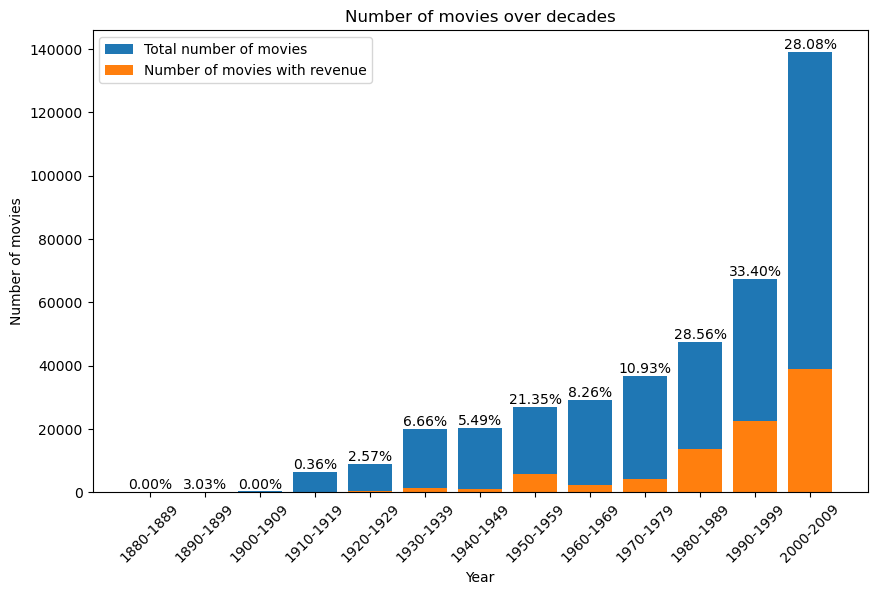

In [9]:
plt.figure(figsize=(10, 6))

# Plot bar plot of number of movies per year
tot_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval.index], 
                nb_movies_per_interval.values, label='Total number of movies')
revenue_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval_revenue.index],
                    nb_movies_per_interval_revenue.values, label='Number of movies with revenue')

plt.title('Number of movies over decades')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.tick_params(axis='x', rotation=45)
plt.legend()

# Add the percentage on top of each bar
for i, tot_bar in enumerate(tot_bar):
    height_tot_bar = tot_bar.get_height()
    height_revenue_bar = revenue_bar[i].get_height()
    percent = height_revenue_bar/height_tot_bar *100
    plt.text(tot_bar.get_x() + tot_bar.get_width() / 2, height_tot_bar + 5, 
             f'{percent:.2f}%', ha='center', va='bottom')

# Show graph
plt.show()

The percentage of revenue data increases through the year. It might be more relevant to perform our analysis on a subset of the years for which the revenue information is more present, therefore we decide to take **movies starting from 1950**.

In [10]:
# Remove all movies that where released before 1950
character_movies_filtered = character_movies_filtered[character_movies_filtered.year >= 1950]

# Look at the percentage of revenue data in this subset:
# Compute the total number of movies
nb_movies_selec = len(character_movies_filtered['movieID'].unique())

# Compute the number of movies for which we box office revenue
character_movies_filtered_revenue_selec = character_movies_filtered[['movieID', 'revenue']]
character_movies_filtered_revenue_selec = character_movies_filtered_revenue_selec.dropna()
nb_movies_selec_revenue = len(character_movies_filtered_revenue_selec['movieID'].unique())

print(f"The percentage of movies for which we have the revenue after 1950: {nb_movies_selec_revenue/nb_movies_selec*100 :.2f}%")

The percentage of movies for which we have the revenue after 1950: 15.99%


##### C. Percentage per country
Let's have a look at the **amount of revenue data per country**. We aggregate our data to obtain a dataframe counting the number of movies with known revenue per country, keeping countries that shot at least 200 movies.

In [11]:
from helpers import sort_words, create_words_database
# Make deep copy for the country analysis
df_country = character_movies_filtered.copy()

# Change countries into a list of String
df_country['countries'] = df_country['countries'].str.extract(r'\"([\w\s]+)\"')
df_country['countries'] = df_country['countries'].apply(lambda x: [x] if pd.notna(x) else ['Unknown'])

# Count the number of movies per country
countries_list = df_country['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country = dict(sorted(nb_movies_per_country.items(), key=lambda item: item[1]))
# Remove countries that shot less than 200 movies
nb_movies_per_country = {country: nb for country, nb in nb_movies_per_country.items() if nb >= 200}


# Count the number of movies with known revenue per country
countries_list = df_country.dropna(subset=['revenue'])['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country_revenue = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country_revenue = dict(sorted(nb_movies_per_country_revenue.items(), key=lambda item: item[1]))


# Keep countries with more than 200 movies and add to nb_movies_per_country_revenue countries without revenue data (set their number of movies to zero)
country_200_movie = list(nb_movies_per_country.keys())
nb_movies_per_country_revenue = {country: nb for country, nb in nb_movies_per_country_revenue.items() if country in country_200_movie}
nb_movies_per_country_revenue.update({country: 0 for country in country_200_movie if country not in nb_movies_per_country_revenue})
nb_movies_per_country_revenue = {country: nb_movies_per_country_revenue[country] for country in nb_movies_per_country}

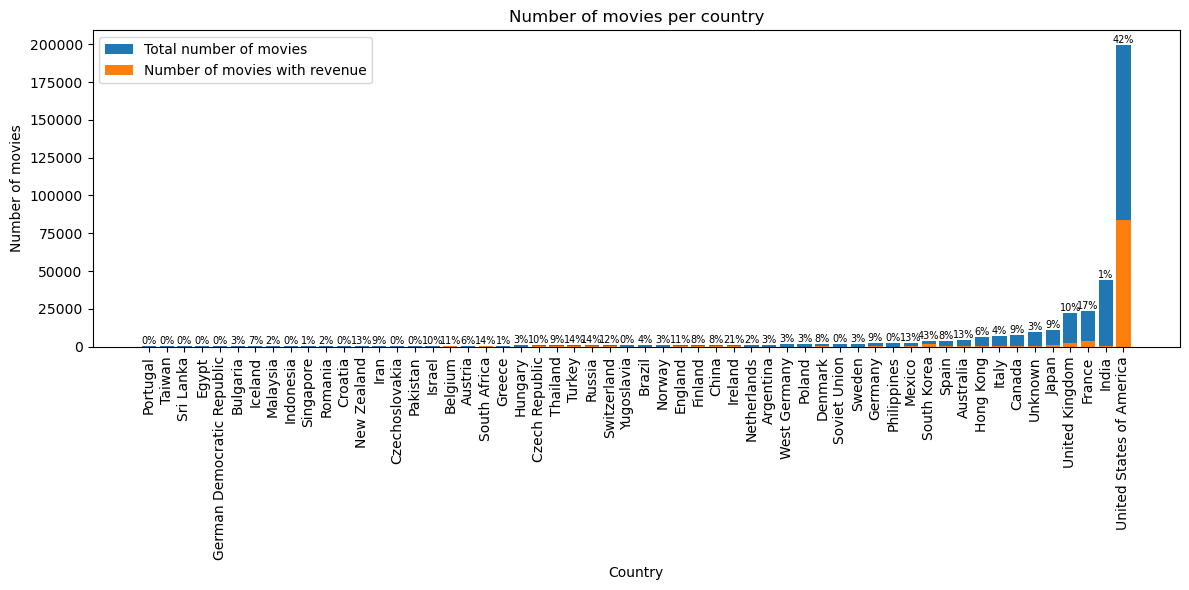

In [12]:
# Extract the names of the countries and the value from each dictionary
country_names = list(nb_movies_per_country.keys())
nb_movies_tot = list(nb_movies_per_country.values())
nb_movies_revenue = list(nb_movies_per_country_revenue.values())

# Make a list of indices for the position of the bars
indices = range(len(country_names))

# Plot histogram
plt.figure(figsize=(12, 6))
bars_tot = plt.bar(indices, nb_movies_tot, label='Total number of movies')
bars_revenue = plt.bar(indices, nb_movies_revenue, label='Number of movies with revenue')

# Add label and title
plt.xlabel('Country')
plt.ylabel('Number of movies')
plt.title('Number of movies per country')
plt.xticks(indices, country_names, rotation=90)

# Add the percentage on top of each bar
for i, bars_tot in enumerate(bars_tot):
    height_bars_tot = bars_tot.get_height()
    height_bars_revenue = bars_revenue[i].get_height()
    percent = height_bars_revenue/height_bars_tot *100
    plt.text(bars_tot.get_x() + bars_tot.get_width() / 2, height_bars_tot + 5,
             f'{percent:.0f}%', ha='center', va='bottom', size=7)


# Show legend and histogram
plt.legend()
plt.tight_layout()
plt.show()

From this plot we can see that the majority of the movies in our dataset come from the U.S. and have a high percentage of revenue information. From this we decided to keep only **movies that were made in the U.S.**

In [13]:
# Keep only movies that where made in the U.S.
character_movies_filtered = character_movies_filtered[
    character_movies_filtered.countries.apply(lambda x:"United States of America" in x)]

# Keep only movies for which we have the revenue
character_movies_filtered = character_movies_filtered.dropna(subset=['revenue'])

# Compute the number of movies left
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())

print(f'The remaining number of movies after the filtration is: {nb_tot_filtered_movies}.')

The remaining number of movies after the filtration is: 6520.


Now that we have filtered our data to have only **U.S. movies which where released after and including the year 1950** and that have the revenue data, we'll look at the data from the actors.

#### D. Data from actors

We'll look at the amount of data available for the following actors features:
- Name
- Date of birth
- Age
- Gender
- Ethnicity

In [14]:
# Compute the total number of characters and actors
nb_actors = len(character_movies_filtered['name_actor'].unique())

# Compute the number of actors for which we have the name
character_movies_name = character_movies_filtered[['name_actor']]
character_movies_name = character_movies_name.dropna()
nb_actors_name = len(character_movies_name['name_actor'].unique())

# Compute the number of actors for which we have the date of birth
character_movies_birth = character_movies_filtered[['birth', 'name_actor']]
character_movies_birth = character_movies_birth.dropna()
nb_actors_birth = len(character_movies_birth['name_actor'].unique())

# Computer the number of actors for which we have the age (positive number)
character_movies_age = character_movies_filtered[['age', 'name_actor']]
character_movies_age = character_movies_age.dropna()
character_movies_age = character_movies_age[character_movies_age.age>=0]
nb_actors_age = len(character_movies_age['name_actor'].unique())

# Compute the number of actors for which we have the gender
character_movies_gender = character_movies_filtered[['gender', 'name_actor']]
character_movies_gender = character_movies_gender.dropna()
nb_actors_gender = len(character_movies_gender['name_actor'].unique())


# Compute the number of actors for which we have the ethnicity
character_movies_ethnicity = character_movies_filtered[['ethnicity', 'name_actor']]
character_movies_ethnicity = character_movies_ethnicity.dropna()
nb_actors_ethnicity = len(character_movies_ethnicity['name_actor'].unique())

# Print the results
print(f"The total number of actors we have is: {nb_actors}")
print(f"The percentage of actors for which we have the name is: {nb_actors_name/nb_actors*100 :.5f}")
print(f"The percentage of actors for which we have the birth date is: {nb_actors_birth/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the age is: {nb_actors_age/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the gender is: {nb_actors_gender/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the ethnicity is: {nb_actors_ethnicity/nb_actors*100 :.2f}")

The total number of actors we have is: 29674
The percentage of actors for which we have the name is: 99.99663
The percentage of actors for which we have the birth date is: 63.55
The percentage of actors for which we have the age is: 61.42
The percentage of actors for which we have the gender is: 84.89
The percentage of actors for which we have the ethnicity is: 14.77


From this analysis we can see that we have enough information on the gender and on the age (esp. with birth date) of the actors. However ethnicity data is often missing. Thus, it might be good to **filter only for birth date and gender**.

In [15]:
# Filter for birth date
character_movies_filtered = character_movies_filtered.dropna(subset=['birth'])

# Apply complete_date function to all birth dates to format them
character_movies_filtered['birth'] = character_movies_filtered['birth'].apply(complete_date)
character_movies_filtered['birth'] = pd.to_datetime(character_movies_filtered['birth'], format='%Y-%m-%d', errors='coerce')

# Get rid of aberrant age values of actors at movie release date
character_movies_filtered = character_movies_filtered[character_movies_filtered.birth.dt.year < character_movies_filtered.year]

# Filter for gender (NaN and aberrant values)
character_movies_filtered = character_movies_filtered.dropna(subset=['gender'])
character_movies_filtered = character_movies_filtered[
    (character_movies_filtered.gender=='F') | (character_movies_filtered.gender=='M')]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6495.
The remaining number of actors is: 18633.


##### E. Number of movies

Now that we have reduced our dataset to this smaller subset we can see that data handling will not be a problem. Finally we'll look at the distribution of the number of movies played by actor.

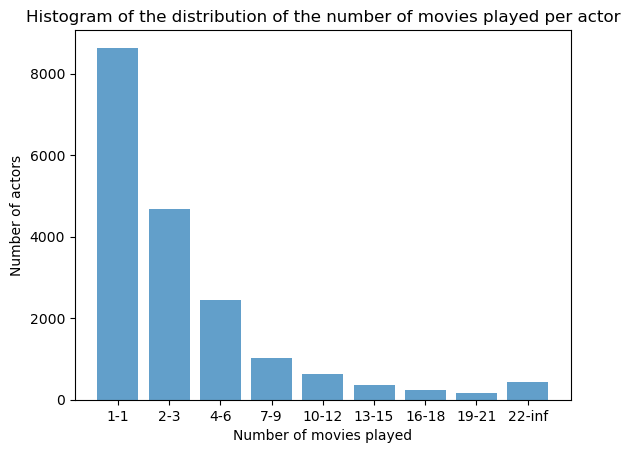

In [16]:
# List all actors name (for filtered data)
actors_names = character_movies_filtered['name_actor'].tolist()

#count the repertition number of each actor name
nb_mov_actor = create_words_database(sorted(actors_names))

# Sort the actors by ascending order of movies played
nb_mov_actor = dict(sorted(nb_mov_actor.items(), key=lambda item: item[1]))

# Define intervals
intervals = [1, 3, 6, 9, 12, 15, 18, 21]

# Initialize a dictionary to stock the number of actors in each interval
actors_per_interval = {i: 0 for i in range(len(intervals) + 1)}

# Count the number of actors in each interval
for actor, index in nb_mov_actor.items():
    for i, threshold in enumerate(intervals):
        if index <= threshold:
            actors_per_interval[i] += 1
            break
    else:
        actors_per_interval[len(intervals)] += 1

# Plot histogram
plt.bar(actors_per_interval.keys(), actors_per_interval.values(), align='center', alpha=0.7)
plt.xticks(list(actors_per_interval.keys()), [f"{i+1}-{j}" for i, j in zip([0] + intervals, intervals + [float('inf')])])
plt.xlabel('Number of movies played')
plt.ylabel("Number of actors")
plt.title('Histogram of the distribution of the number of movies played per actor')
plt.show()

From this histogram we see that many actors played in only one movie so we will further decrease the size of our dataset to only keep actors that played in **at least two movies**.

In [17]:
from helpers import at_least_2_movies

# Apply filtering function to actor dictionary
filtered_actors = dict(filter(at_least_2_movies, nb_mov_actor.items()))

# Filter dataset
character_movies_filtered = character_movies_filtered[character_movies_filtered['name_actor'].isin(filtered_actors.keys())]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6443.
The remaining number of actors is: 9997.


## 3. IMDb dataset integration

For further analysis, we'll have to define the notion of success of a movie. For this purpose, we decide to include a measure of public satisfaction given by the IMDb ratings. IMDb is a popular source for movies, TV shows and celebrity content where users can cast a vote from 1 to 10 on every released title in the database.

In this part we will take care of loading this new dataset and merging it with our filtered dataset ('character_movies_filtered')
- IMDb_ratings: dataframe of ratings
- IMDb_basics: dataframe of information including the original name

Both datasets are linked by a constant ID 'tconst' that allows us to merge them into a single dataframe.

In [18]:
# Load IMDb datasets into pandas dataframes
IMDb_ratings = pd.read_table(DATA_FOLDER + '/title.ratings.tsv.gz')
IMDb_basics = pd.read_table(DATA_FOLDER +  '/title.basics.tsv.gz')

# Merge ratings with names
IMDb = pd.merge(IMDb_ratings, IMDb_basics, on='tconst')

/tmp/ipykernel_9052/3889453638.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_basics = pd.read_table(DATA_FOLDER +  '/title.basics.tsv.gz')


We will now merge the IMDb dataframe with our filtered dataframe 'character_movies_filtered'. As there is no direct ID linking these datasets, we will merge them on the movie name. To ensure that we avoid merging movies having the same name, we'll also merge on the release date of the movie. Let's first store in a list the movies for which we have the same name but different release date (e.g. Twilight).

In [19]:
# Get a list of the movie names (name_movie) for which we have multiple releaseDate values
subset = character_movies_filtered.drop_duplicates(subset = ['name_movie', 'releaseDate'])
grouped = subset.groupby('name_movie').releaseDate.count()
list_mlt_dates = list(grouped[grouped>1].index)

But by naively removing all movies that do not have a 'startYear' in the IMDb dataset we loose many movies that we could have merged using only the movie name.

Further more some movie names in the IMDb ratings have multiple ratings values (e.g. different versions). To deal with this we keep only the rating values for which we have the most votes. 

Then we set aside movies that have multiple year and merge them witht the IMDb ratings using the movie name and the release year. For the other movies we simply merged on the movie name. This allowed to reduce the loss of movies from ~10% to ~4.6%.

In [20]:
# For movies with multiple releaseDate: keep only movies with startYear (necessary for the upcoming merge)
IMDb_with_year = IMDb[IMDb.originalTitle.isin(list_mlt_dates)]
IMDb_with_year = IMDb_with_year.dropna(subset = 'startYear')
IMDb_with_year = IMDb_with_year[~(IMDb_with_year.startYear =='\\N')]

# Convert startYear from string to float (for upcoming merge)
IMDb_with_year.startYear = IMDb_with_year.startYear.astype(float)

# IMDb dataset with movies that do not have multiple releaseDate values of multiple IMDb ratings
IMDb = IMDb[~IMDb.originalTitle.isin(list_mlt_dates)]

# If multiple different averageRating for a same movie then keep the value with the most votes (numVotes)
IMDb_with_year = IMDb_with_year.sort_values(by='numVotes', ascending=False)
IMDb = IMDb.sort_values(by='numVotes', ascending=False)
IMDb_with_year = IMDb_with_year.drop_duplicates(subset=['originalTitle', 'startYear'] , keep='first')
IMDb = IMDb.drop_duplicates(subset='originalTitle' , keep='first')

In [21]:
# Keep only the desired columns
IMDb = IMDb[['originalTitle', 'averageRating']]
IMDb_with_year = IMDb_with_year[['originalTitle', 'averageRating', 'startYear']]

In [22]:
# Populate the characters - movies dataset with the IMDb ratings (movies with multiple averageRating of releaseDate)
character_movies_filtered_imdb = pd.merge(character_movies_filtered, IMDb_with_year, how='left',
                                          left_on=['name_movie', 'year'], right_on=['originalTitle', 'startYear'])

# Remove unwanted columns (duplicated during merge)
character_movies_filtered_imdb = character_movies_filtered_imdb.drop(labels = ['originalTitle', 'startYear'], axis=1)

# Populate the characters - movies dataset with the IMDb ratings
character_movies_filtered_imdb = pd.merge(character_movies_filtered_imdb, IMDb, how='left',
                                          left_on='name_movie', right_on='originalTitle')

# Combine the two averageRating we got from the merges (replace the null NaN from one column with values form the other)
character_movies_filtered_imdb['averageRating'] = character_movies_filtered_imdb.averageRating_x.combine_first(character_movies_filtered_imdb.averageRating_y)
character_movies_filtered_imdb = character_movies_filtered_imdb.drop(labels = ['originalTitle', 'averageRating_x', 'averageRating_y'], axis=1)

Now we filter our merged dataframe to keep only movies for which we have the IMDb rating. We can then evalutate the number and the impact of the lost movies during this operation.

In [23]:
# Filter for entries that have IMDb ratings
character_movies_filtered_imdb = character_movies_filtered_imdb.dropna(subset = 'averageRating')

# Look at the movie loss from the IMDb merge
lost_movies = len(character_movies_filtered.movieID.unique()) - len(character_movies_filtered_imdb.movieID.unique())

print(f'The number of movies that we lost by adding the IMDb ratings is: {lost_movies}. \
This represents a loss of {lost_movies*100/len(character_movies_filtered.movieID.unique()): .2f}%')

The number of movies that we lost by adding the IMDb ratings is: 299. This represents a loss of  4.64%


As we can see the loss is only of 4.64% so it is reasonable and we will carry on with our new dataframe.

In [24]:
# To be able to import variables names in other notebooks, we store what we need 
%store character_movies_filtered_imdb
%store nb_tot_filtered_actors

Stored 'character_movies_filtered_imdb' (DataFrame)
Stored 'nb_tot_filtered_actors' (int)
